We check the SVM procedure outlined in Theorem 22.29.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.array([
    [0.5, 1.5, -1.],
    [1.0, 0.5, -1.],
    [1.1, 0.55, -1.],
    [1.0, 1.9, -1.],
    [1.4, 1.0, -1.],
    [1.0, 1.0, -1.],
    [2., 2.5, 1.],
    [1.65, 2.0, 1.],
    [1.3, 2.5, 1.],
    [2.2, 2.3, 1.],
    [2.0, 2.0, 1.],
    [2.1, 1.8, 1.],
])

In [3]:
n = data.shape[0]

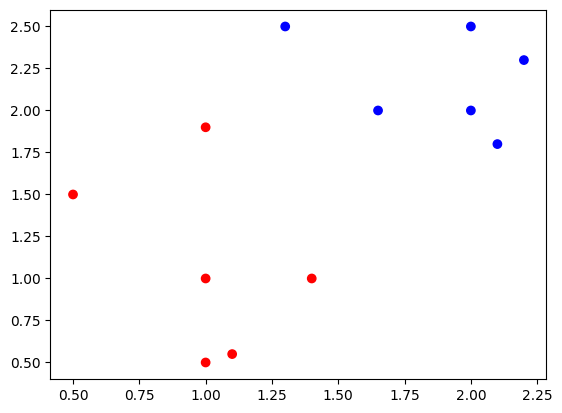

In [4]:
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], color=np.where(data[:, 2] == -1, 'red', 'blue'));

### CVXPY

In [5]:
import cvxpy as cp

In [6]:
P = np.diag(data[:, 2]) @ data[:, :2] @ data[:, :2].T @ np.diag(data[:, 2])

In [7]:
alpha = cp.Variable(n)
prob = cp.Problem(cp.Maximize(cp.sum(alpha) - cp.quad_form(alpha, P) / 2), [data[:, 2] @ alpha == 0])
prob.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var1, [[2.50 1.25 ... -4.00 -3.75]
 [1.25 1.25 ... -3.00 -3.00]
 ...
 [-4.00 -3.00 ... 8.00 7.80]
 [-3.75 -3.00 ... 7.80 7.65]])

The optimiser detects that the matrix is slightly non-positive definite and refuses to proceed.

In [8]:
np.linalg.eig(P)[0]

array([ 6.36639470e+01+0.00000000e+00j,  1.84910965e-17+0.00000000e+00j,
        1.86105303e+00+0.00000000e+00j,  1.52012227e-15+0.00000000e+00j,
        2.03758924e-16+1.26625654e-15j,  2.03758924e-16-1.26625654e-15j,
       -1.31878442e-15+3.33070243e-16j, -1.31878442e-15-3.33070243e-16j,
       -1.17264882e-15+0.00000000e+00j,  7.76973407e-17+1.83602137e-16j,
        7.76973407e-17-1.83602137e-16j,  1.89268426e-46+0.00000000e+00j])

### CVXOPT

In [9]:
from cvxopt import matrix, solvers

In [10]:
P = matrix(np.diag(data[:, 2]) @ data[:, :2] @ data[:, :2].T @ np.diag(data[:, 2]))
q = matrix(-np.ones(n))
G = matrix(-np.eye(n))
h = matrix(np.zeros(n))
A = matrix(data[:, 2], (1, n))
b = matrix(0.0)

In [11]:
sol = solvers.qp(P, q, G, h, A, b)
alpha = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0: -2.4078e+00 -6.0676e+00  3e+01  4e+00  2e+00
 1: -3.9782e+00 -6.0177e+00  5e+00  7e-01  3e-01
 2: -5.9347e+00 -6.0317e+00  6e-01  1e-01  5e-02
 3: -5.7513e+00 -5.7529e+00  9e-03  2e-03  7e-04
 4: -5.7485e+00 -5.7485e+00  9e-05  2e-05  7e-06
 5: -5.7485e+00 -5.7485e+00  9e-07  2e-07  7e-08
 6: -5.7485e+00 -5.7485e+00  9e-09  2e-09  7e-10
Optimal solution found.


In [12]:
a = np.sum((alpha * data[:, 2]).reshape(-1, 1) * data[:, :2], axis=0)
i = np.argwhere(np.abs(alpha) > 1e-6)[0, 0]  # index of the first support vector
a0 = 1 / data[i, 2] - data[i, :2] @ a

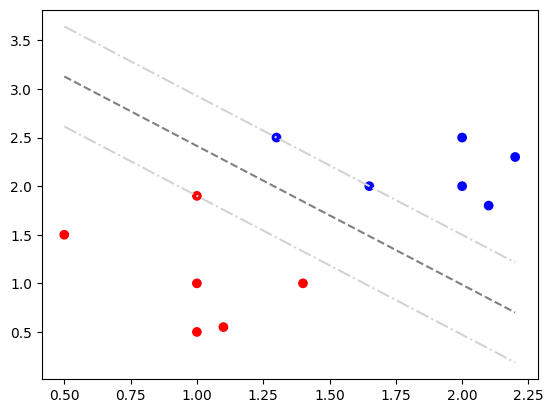

In [13]:
xs = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100)
fig, ax = plt.subplots()
ax.plot(xs, -(a0 + a[0] * xs) / a[1], linestyle='--', color='gray');
ax.plot(xs, (1 - a0 - a[0] * xs) / a[1], linestyle='-.', color='lightgray');
ax.plot(xs, (-1 - a0 - a[0] * xs) / a[1], linestyle='-.', color='lightgray');
ax.scatter(data[:, 0], data[:, 1], color=np.where(data[:, 2] == -1, 'red', 'blue'));

### Scikit-learn

In [14]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

In [15]:
X = data[:, :2]
y = data[:, 2]

In [16]:
svm_fit = svm.SVC(kernel='linear', C=1e10).fit(X, y)

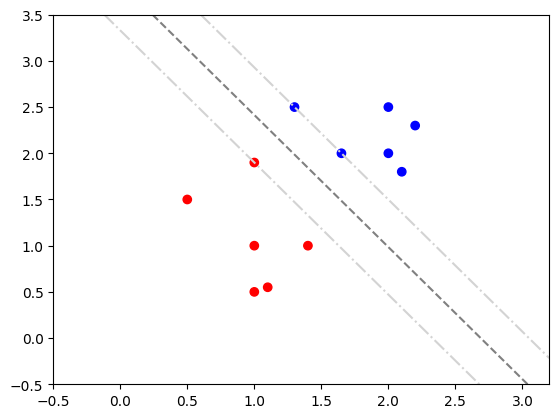

In [17]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    svm_fit,
    X,
    ax=ax,
    response_method="decision_function",
    plot_method="contour",
    levels=[-1, 0, 1],
    colors=["lightgray", "gray", "lightgray"],
    linestyles=["-.", "--", "-."],
);
ax.scatter(X[:, 0], X[:, 1], color=np.where(data[:, 2] == -1, 'red', 'blue'));